<h3><center>Predicting Stroke Risk</center></h3>   

    
<center>Sam Loyd</center>
<center>June 2021</center> 

In [1]:
# Required Modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from pycaret.classification import *
# import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
# from xgboost import XGBClassifier
from collections import Counter

## Data Analysis - EDA

In [2]:
# Pull in data for stroke data 
stroke_df = pd.read_csv("data\\healthcare-dataset-stroke-data.csv")

In [3]:
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [4]:
# Correct data types
stroke_df['stroke'] = stroke_df['stroke'].astype(bool)
stroke_df['hypertension'] = stroke_df['hypertension'].astype(bool)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(bool)

In [5]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
2,31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
3,60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True
4,1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,True


In [6]:
# Apply profie and create html report
# Commented out for performance
# prof = ProfileReport(stroke_df,title="Pandas Profiling Report - Stroke Data", explorative=True)
# prof.to_file(output_file='stroke-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

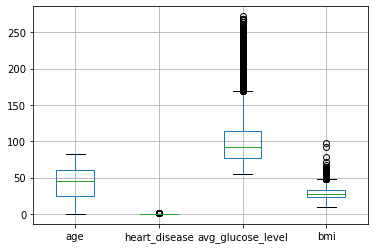

In [7]:
# Pandas-profiling is lacking in outlier analysis visuals so those are included here.

# Box and whisker plots for outlier analysis.
boxplot = stroke_df.boxplot(column=['age', 'heart_disease', 'avg_glucose_level','bmi'])

While outliers were discovered, they were within acceptable ranges according to domain knowledge.
They will not be removed.

## Data Wrangling  
Impute missing values found in the EDA process using pandas-profile report.

In [8]:
stroke_df.bmi.isnull().sum()

201

In [9]:
# Take a deeper look at these
stroke_null = stroke_df[stroke_df.bmi.isnull()]

In [10]:
stroke_null.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
8,27419,Female,59.0,False,False,Yes,Private,Rural,76.15,NaN,Unknown,True
13,8213,Male,78.0,False,True,Yes,Private,Urban,219.84,NaN,Unknown,True
19,25226,Male,57.0,False,True,No,Govt_job,Urban,217.08,NaN,Unknown,True
27,61843,Male,58.0,False,False,Yes,Private,Rural,189.84,NaN,Unknown,True


In [11]:
# about 25%
stroke_null.stroke.value_counts()

False    161
True      40
Name: stroke, dtype: int64

In [12]:
# about 5%
stroke_df.stroke.value_counts()

False    4861
True      249
Name: stroke, dtype: int64

That seems too many data points that have had strokes to throw out given that it is already only 5%.  
As in most cases of missingness there are no good options, but in this case, it does the least harm to impute the mean.

In [13]:
stroke_df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,4909.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.854067
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.500000
50%,36932.000000,45.000000,91.885000,28.100000
75%,54682.000000,61.000000,114.090000,33.100000
max,72940.000000,82.000000,271.740000,97.600000


In [14]:
# Gather mean for imputation
bmi_mean = stroke_df.bmi.mean()

In [15]:
# Show value
bmi_mean

28.893236911794673

In [16]:
stroke_df = stroke_df.fillna(bmi_mean)

In [17]:
# Contrast effect on statistics
stroke_df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.698018
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.800000
50%,36932.000000,45.000000,91.885000,28.400000
75%,54682.000000,61.000000,114.090000,32.800000
max,72940.000000,82.000000,271.740000,97.600000


In [18]:
# Verify change
stroke_df.bmi.isnull().sum()

0

## Model Prep

In [19]:
# Prepare for modeling
# Make numeric
stroke_df['stroke'] = stroke_df['stroke'].astype(int)
stroke_df['hypertension'] = stroke_df['hypertension'].astype(int)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(int)

In [20]:
# Binary values
# 1 unknown, but I made it female since it was the most common
stroke_df['gender'] = np.where(stroke_df['gender']=='male', 1, 0)

stroke_df['Residence_type'] = np.where(stroke_df['Residence_type']=='Urban', 1, 0)
stroke_df['ever_married'] = np.where(stroke_df['ever_married']=='Yes', 1, 0)

### One Hot Encoding

In [21]:
work_type_one_hot = pd.get_dummies(stroke_df['work_type'])

In [22]:
work_type_one_hot.columns = ['work_type_gov', 'work_type_never','work_type_priv', 'work_type_self','work_type_child']

In [23]:
smoking_status_one_hot = pd.get_dummies(stroke_df['smoking_status'])

In [24]:
smoking_status_one_hot.columns = ['smok_stat_unk', 'smok_stat_form','smoke_stat_nev','smok_stat_curr']

In [25]:
model_stroke_df = pd.concat([stroke_df,work_type_one_hot,smoking_status_one_hot], axis = 1)

In [26]:
# Clean up
model_stroke_df.drop('work_type', axis=1, inplace=True)
model_stroke_df.drop('Residence_type', axis=1, inplace=True) 
model_stroke_df.drop('smoking_status', axis=1, inplace=True) 
model_stroke_df.drop('id', axis=1, inplace=True) 

In [27]:
model_stroke_df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr
0,0,67.0,0,1,1,228.69,36.600000,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,202.21,28.893237,1,0,0,0,1,0,0,0,1,0
2,0,80.0,0,1,1,105.92,32.500000,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,171.23,34.400000,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,174.12,24.000000,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,83.75,28.893237,0,0,0,1,0,0,0,0,1,0
5106,0,81.0,0,0,1,125.20,40.000000,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,82.99,30.600000,0,0,0,0,1,0,0,0,1,0
5108,0,51.0,0,0,1,166.29,25.600000,0,0,0,1,0,0,0,1,0,0


### Normalize the numeric data
Non Gaussian

In [28]:
# Normalize with minmax_scale
model_stroke_df[['age','avg_glucose_level','bmi']] = minmax_scale(model_stroke_df[['age','avg_glucose_level','bmi']])

In [29]:
model_stroke_df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr
0,0,0.816895,0,1,1,0.801265,0.301260,1,0,0,1,0,0,0,1,0,0
1,0,0.743652,0,0,1,0.679023,0.212981,1,0,0,0,1,0,0,0,1,0
2,0,0.975586,0,1,1,0.234512,0.254296,1,0,0,1,0,0,0,0,1,0
3,0,0.597168,0,0,1,0.536008,0.276060,1,0,0,1,0,0,0,0,0,1
4,0,0.963379,1,0,1,0.549349,0.156930,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0.975586,1,0,1,0.132167,0.212981,0,0,0,1,0,0,0,0,1,0
5106,0,0.987793,0,0,1,0.323516,0.340206,0,0,0,0,1,0,0,0,1,0
5107,0,0.426270,0,0,1,0.128658,0.232532,0,0,0,0,1,0,0,0,1,0
5108,0,0.621582,0,0,1,0.513203,0.175258,0,0,0,1,0,0,0,1,0,0


In [30]:
# Create X from the features
X = model_stroke_df.drop(columns=['stroke'])

# Create y from output
y = model_stroke_df[['stroke']]

# X, y = smote.fit_resample(model_stroke_df.drop(columns=['stroke']),model_stroke_df[['stroke']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [31]:
# Treating Imbalance Data using SMOTE
smote=SMOTETomek()
X_train,y_train=smote.fit_resample(X_train,y_train)

In [32]:
# Much better balance
y_train.value_counts() 

stroke
1         2855
0         2855
dtype: int64

### Deal with stroke being extremely imbalanced in this data set.

## Model Selection with PyCaret

In [33]:
# PyCaret requires them in one dataframe
X_train_caret_cat = X_train.copy()
X_train_caret_cat['stroke'] = y_train['stroke']
X_train_caret_cat

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr,stroke
0,0,0.548340,0,0,1,0.047826,0.186712,0,0,1,0,0,1,0,0,0,0
1,0,0.475098,0,0,1,0.088496,0.217640,0,0,0,1,0,0,0,0,1,0
2,0,0.902344,0,0,1,0.262303,0.130584,1,0,0,0,0,0,0,1,0,0
3,0,0.877930,0,0,1,0.224633,0.256586,0,0,0,1,0,0,1,0,0,0
4,0,0.340820,0,0,1,0.043948,0.135166,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,0,0.505377,0,0,1,0.141572,0.183495,0,0,1,0,0,0,0,1,0,1
5706,0,0.876281,0,1,1,0.722633,0.247330,0,0,1,0,0,1,0,0,0,1
5707,0,0.644969,0,0,0,0.217408,0.224995,0,0,1,0,0,0,0,0,1,1
5708,0,0.568841,0,0,1,0.166218,0.183953,0,0,1,0,0,0,0,1,0,1


In [34]:
exp_clf_cat = setup(X_train_caret_cat, target='stroke')

,Description,Value
0,session_id,2736
1,Target,stroke
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5710, 17)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [35]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [36]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9519,0.9916,0.9550,0.9485,0.9516,0.9039,0.9043,0.3350
lightgbm,Light Gradient Boosting Machine,0.9412,0.9891,0.9489,0.9335,0.9410,0.8824,0.8828,0.2430
et,Extra Trees Classifier,0.9247,0.9804,0.9656,0.8916,0.9270,0.8495,0.8525,0.1360
catboost,CatBoost Classifier,0.9232,0.9796,0.9530,0.8982,0.9247,0.8464,0.8482,1.3260
rf,Random Forest Classifier,0.9194,0.9767,0.9590,0.8876,0.9218,0.8389,0.8419,0.1530
dt,Decision Tree Classifier,0.8754,0.8754,0.8817,0.8688,0.8751,0.7508,0.7511,0.0110
knn,K Neighbors Classifier,0.8671,0.9291,0.9621,0.8071,0.8777,0.7347,0.7486,0.0330
gbc,Gradient Boosting Classifier,0.8548,0.9408,0.9014,0.8225,0.8601,0.7099,0.7132,0.1400
ada,Ada Boost Classifier,0.8138,0.8934,0.8524,0.7887,0.8192,0.6279,0.6302,0.0690
ridge,Ridge Classifier,0.8078,0.0000,0.8711,0.7707,0.8178,0.6161,0.6214,0.0080


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=2736, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

## Parameter Tuning

In [45]:
# Select best model
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9425,0.9911,0.9394,0.9442,0.9418,0.8850,0.8850
1,0.9550,0.9930,0.9495,0.9592,0.9543,0.9100,0.9100
2,0.9500,0.9893,0.9394,0.9588,0.9490,0.9000,0.9002
3,0.9550,0.9941,0.9848,0.9286,0.9559,0.9100,0.9117
4,0.9625,0.9932,0.9798,0.9463,0.9628,0.9250,0.9256
5,0.9550,0.9928,0.9444,0.9639,0.9541,0.9100,0.9102
6,0.9398,0.9869,0.9239,0.9529,0.9381,0.8796,0.8800
7,0.9524,0.9895,0.9645,0.9406,0.9524,0.9048,0.9051
8,0.9599,0.9944,0.9697,0.9505,0.9600,0.9198,0.9200
9,0.9474,0.9920,0.9545,0.9403,0.9474,0.8947,0.8948


In [46]:
# Find best parameters
xgboost = tune_model(xgboost,optimize = 'Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9150,0.9758,0.8889,0.9362,0.9119,0.8299,0.8309
1,0.9075,0.9803,0.8990,0.9128,0.9059,0.8150,0.8150
2,0.9075,0.9689,0.8838,0.9259,0.9044,0.8149,0.8157
3,0.9200,0.9802,0.9293,0.9109,0.9200,0.8400,0.8402
4,0.9125,0.9753,0.8889,0.9312,0.9096,0.8249,0.8257
5,0.9175,0.9778,0.9040,0.9275,0.9156,0.8349,0.8352
6,0.9023,0.9656,0.8579,0.9389,0.8966,0.8043,0.8072
7,0.9173,0.9711,0.9289,0.9059,0.9173,0.8346,0.8349
8,0.9323,0.9777,0.9343,0.9296,0.9320,0.8647,0.8647
9,0.8897,0.9659,0.8586,0.9140,0.8854,0.7793,0.7808


In [47]:
# Lets look at them
plot_model(xgboost, plot='parameter')

,Parameters
objective,binary:logistic
use_label_encoder,True
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,0.5
gamma,0
gpu_id,-1
importance_type,gain


In [48]:
# Finalize the model
final_xgboost = finalize_model(xgboost)

## Test Data

In [49]:
# predict test data
test_predictions = predict_model(final_xgboost, data=X_test)
test_predictions.Label

4673    0
3232    0
3694    0
1070    0
4163    0
       ..
2030    0
4555    0
1056    0
854     0
4288    0
Name: Label, Length: 1022, dtype: int32

In [50]:
# Check stats
print(classification_report(y_test, test_predictions.Label))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       962
           1       0.12      0.12      0.12        60

    accuracy                           0.90      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.90      0.90      0.90      1022



[Text(0, 0.5, 'None'), Text(0, 1.5, 'Stroke')]

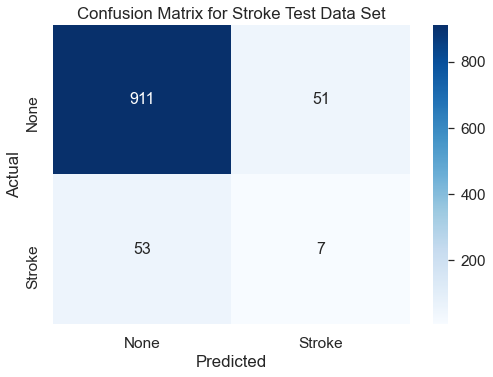

<Figure size 720x504 with 0 Axes>

In [60]:
# Draw confusion matrix 
data = confusion_matrix(y_test, test_predictions.Label)
ax= plt.subplot()

df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,ax = ax, annot_kws={"size": 16},fmt='d')# font size
ax.set_title('Confusion Matrix for Stroke Test Data Set') 
ax.xaxis.set_ticklabels(['None', 'Stroke'])   
ax.yaxis.set_ticklabels(['None', 'Stroke'])

## Validation Data

In [52]:
# predict validation data
val_predictions = predict_model(final_xgboost, data=X_val)
val_predictions.Label

3234    0
3968    0
3335    0
1617    0
4701    0
       ..
830     0
498     0
3427    0
271     0
5059    0
Name: Label, Length: 1022, dtype: int32

In [53]:
# Check stats
print(classification_report(y_val, val_predictions.Label))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       982
           1       0.06      0.07      0.07        40

    accuracy                           0.92      1022
   macro avg       0.51      0.51      0.51      1022
weighted avg       0.93      0.92      0.92      1022



[Text(0, 0.5, 'None'), Text(0, 1.5, 'Stroke')]

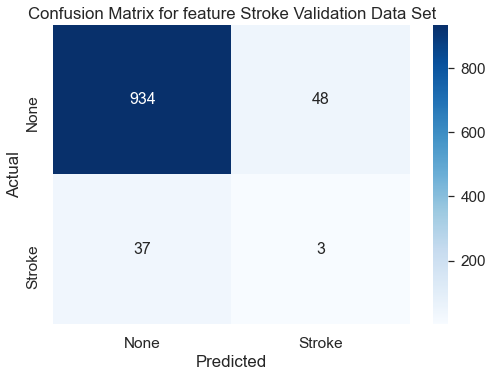

<Figure size 720x504 with 0 Axes>

In [59]:
# Draw confusion matrix 
data = confusion_matrix(y_val, val_predictions.Label)
ax= plt.subplot()

df_cm = pd.DataFrame(data, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,ax = ax, annot_kws={"size": 16},fmt='d')# font size
ax.set_title('Confusion Matrix for feature Stroke Validation Data Set') 
ax.xaxis.set_ticklabels(['None', 'Stroke'])   
ax.yaxis.set_ticklabels(['None', 'Stroke'])